In [3]:
import torch
print(torch.cuda.is_available())

True


In [4]:
!pip install --break-system-packages torchvision

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.7 * len(trainset))
val_size = int(0.1 * len(trainset))
test_size = len(trainset) - train_size - val_size
trainset, valset, testset = torch.utils.data.random_split(trainset, [train_size, val_size, test_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

def train_model(model, criterion, optimizer, num_epochs=5):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss.append(running_loss / total)
        train_acc.append(correct / total)

        # Validation
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss.append(val_running_loss / val_total)
        val_acc.append(val_correct / val_total)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}")

        if epoch > 1 and val_loss[-1] > val_loss[-2]:
            print("Validation loss increased, stopping training.")
            break

    training_time = time.time() - start_time
    return model, train_loss, val_loss, train_acc, val_acc, training_time

def test_model(model):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = correct / total
    return accuracy

# Training AlexNet
alexnet = models.alexnet(pretrained=False)
alexnet.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
alexnet.features[2] = nn.Identity()
alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, 10)

alexnet = alexnet.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

alexnet, alexnet_train_loss, alexnet_val_loss, alexnet_train_acc, alexnet_val_acc, alexnet_time = train_model(alexnet, criterion, optimizer)

# Evaluate AlexNet
alexnet_test_acc = test_model(alexnet)
print(f"AlexNet Test Accuracy: {alexnet_test_acc:.4f}")

# Training ResNet50
resnet50 = models.resnet50(pretrained=False)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)
resnet50 = resnet50.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

resnet50, resnet50_train_loss, resnet50_val_loss, resnet50_train_acc, resnet50_val_acc, resnet50_time = train_model(resnet50, criterion, optimizer)

# Evaluate ResNet50
resnet50_test_acc = test_model(resnet50)
print(f"ResNet50 Test Accuracy: {resnet50_test_acc:.4f}")

print(f"AlexNet Time: {alexnet_time:.2f}s, Parameters: {sum(p.numel() for p in alexnet.parameters())}, Accuracy: {alexnet_test_acc:.4f}")
print(f"ResNet50 Time: {resnet50_time:.2f}s, Parameters: {sum(p.numel() for p in resnet50.parameters())}, Accuracy: {resnet50_test_acc:.4f}")


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


/home/yasir_7/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yasir_7/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 1.7783, Val Loss: 1.4735
Epoch 2/5, Train Loss: 1.4165, Val Loss: 1.2643
Epoch 3/5, Train Loss: 1.2424, Val Loss: 1.1915
Epoch 4/5, Train Loss: 1.1296, Val Loss: 1.0207
Epoch 5/5, Train Loss: 1.0417, Val Loss: 1.0299
Validation loss increased, stopping training.
AlexNet Test Accuracy: 0.6399
Epoch 1/5, Train Loss: 1.9524, Val Loss: 1.6650
Epoch 2/5, Train Loss: 1.8649, Val Loss: 2.0899
Epoch 3/5, Train Loss: 1.7223, Val Loss: 2.2339
Validation loss increased, stopping training.
ResNet50 Test Accuracy: 0.3620
AlexNet Time: 320.85s, Parameters: 57023306, Accuracy: 0.6399
ResNet50 Time: 106.14s, Parameters: 23528522, Accuracy: 0.3620


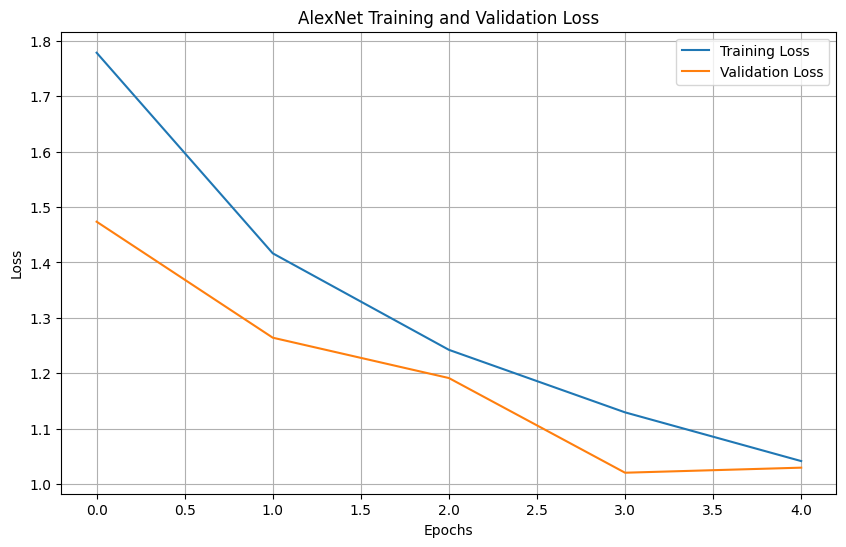

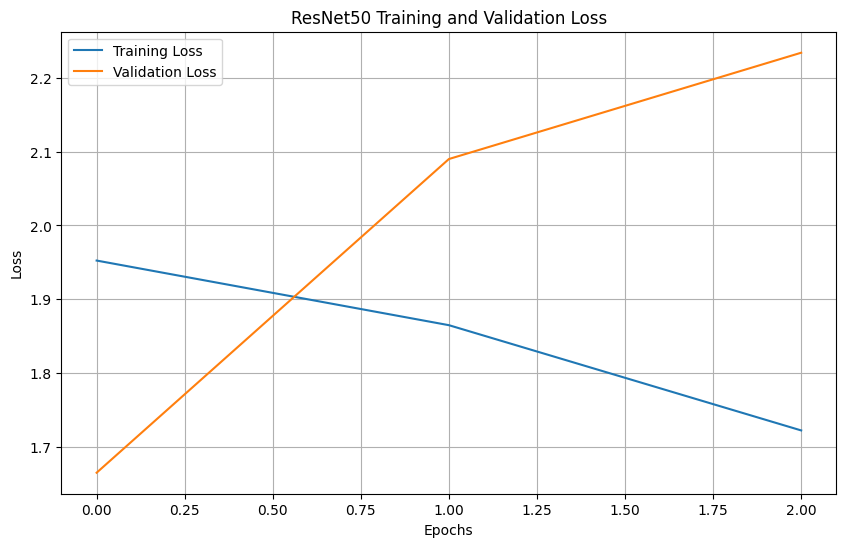

In [6]:
def plot_losses(train_loss, val_loss, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_losses(alexnet_train_loss, alexnet_val_loss, "AlexNet")
plot_losses(resnet50_train_loss, resnet50_val_loss, "ResNet50")


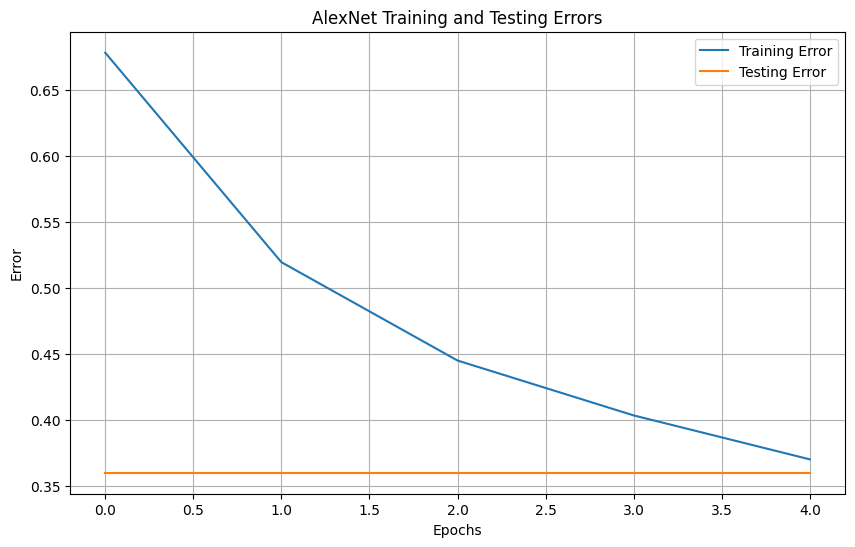

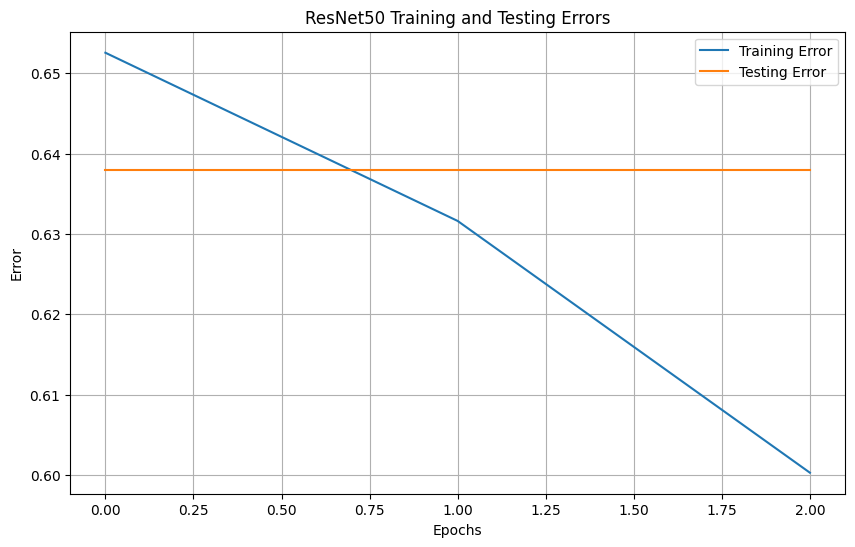

In [7]:
def plot_errors(train_acc, test_acc, model_name):
    train_error = [1 - acc for acc in train_acc]
    test_error = [1 - acc for acc in test_acc]
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_error, label='Training Error')
    plt.plot(test_error, label='Testing Error')
    plt.title(f'{model_name} Training and Testing Errors')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend()
    plt.grid()
    plt.show()

plot_errors(alexnet_train_acc, [alexnet_test_acc] * len(alexnet_train_acc), "AlexNet")
plot_errors(resnet50_train_acc, [resnet50_test_acc] * len(resnet50_train_acc), "ResNet50")


In [ ]:
def visualize_activation_maps_alexnet(model, loader, layer_idx=0, num_filters=8):
    model.eval()
    activation_maps = []

    def hook_fn(module, input, output):
        activation_maps.append(output)

    hook_handle = list(model.features.children())[layer_idx].register_forward_hook(hook_fn)

    inputs, _ = next(iter(loader))
    inputs = inputs.to(device)

    with torch.no_grad():
        _ = model(inputs)

    activation_maps = activation_maps[0].cpu().detach()

    cols = int(np.sqrt(num_filters))
    rows = int(np.ceil(num_filters / cols))

    plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(min(num_filters, activation_maps.size(1))):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(activation_maps[0, i].numpy(), cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Activation Maps from Layer {layer_idx + 1} (AlexNet)", fontsize=16)
    plt.tight_layout()
    plt.show()

    hook_handle.remove()


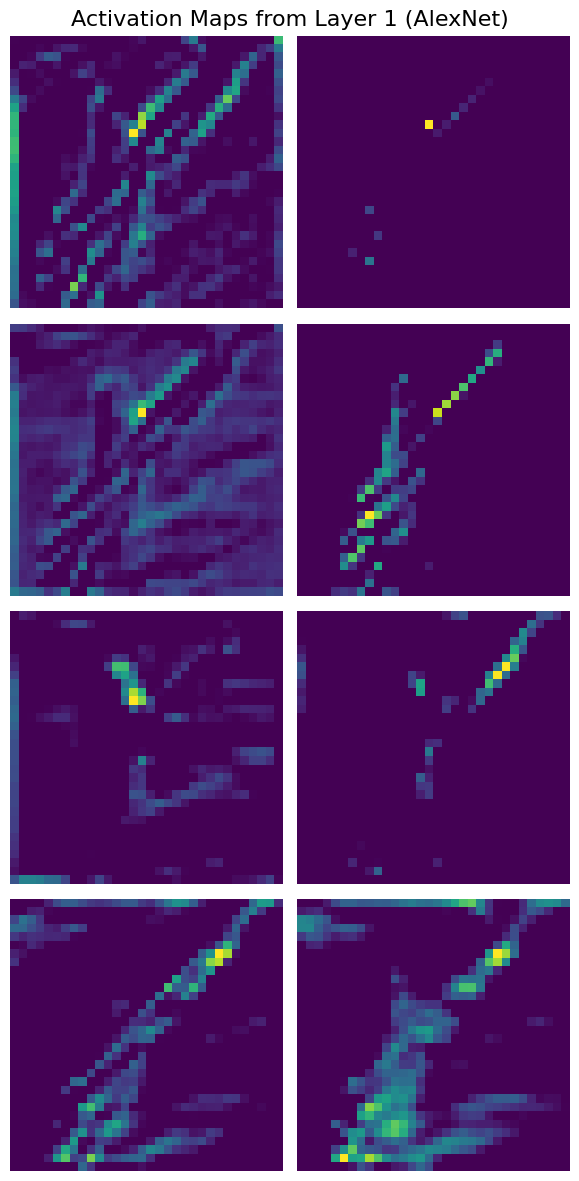

In [9]:
visualize_activation_maps_alexnet(alexnet, testloader, layer_idx=0, num_filters=8)


In [ ]:
def visualize_activation_maps_resnet(model, loader, layer_name="layer1", num_filters=8):
    model.eval()
    activation_maps = []

    def hook_fn(module, input, output):
        activation_maps.append(output)

    layer = dict(model.named_modules())[layer_name]
    hook_handle = layer.register_forward_hook(hook_fn)

    inputs, _ = next(iter(loader))
    inputs = inputs.to(device)

    with torch.no_grad():
        _ = model(inputs)

    activation_maps = activation_maps[0].cpu().detach()

    cols = int(np.sqrt(num_filters))
    rows = int(np.ceil(num_filters / cols))

    plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(min(num_filters, activation_maps.size(1))):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(activation_maps[0, i].numpy(), cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Activation Maps from {layer_name} (ResNet)", fontsize=16)
    plt.tight_layout()
    plt.show()

    hook_handle.remove()


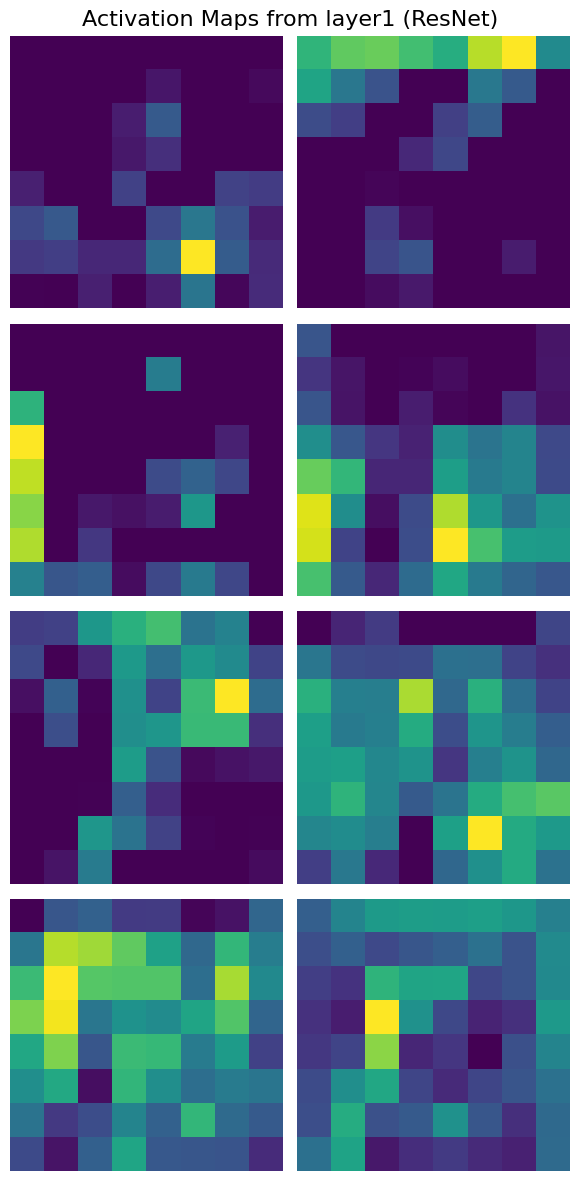

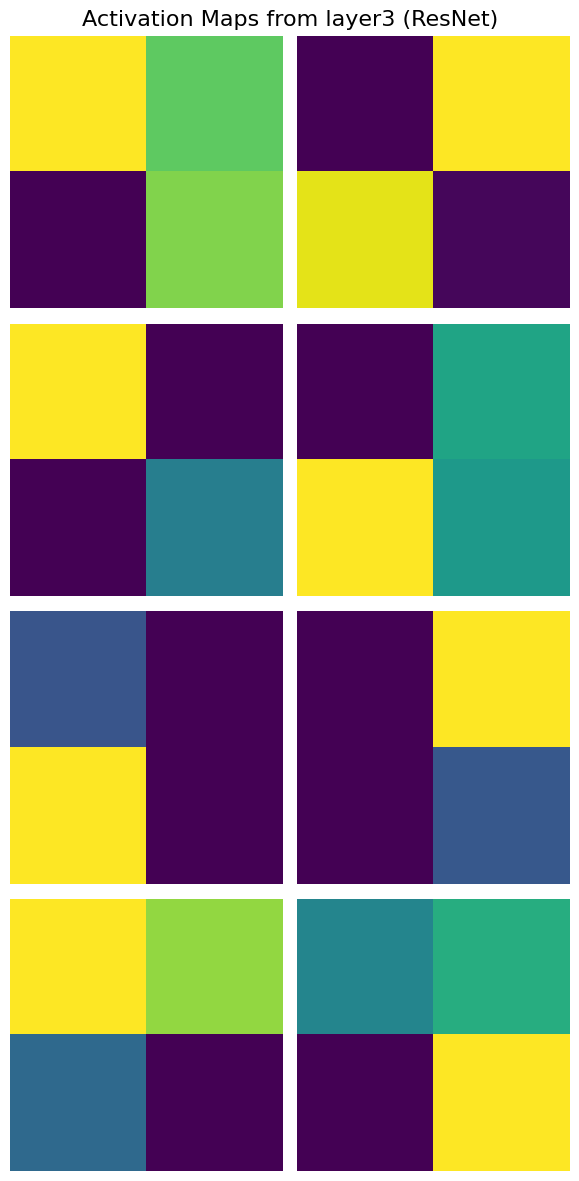

In [18]:
visualize_activation_maps_resnet(resnet50, testloader, layer_name="layer1", num_filters=8)
visualize_activation_maps_resnet(resnet50, testloader, layer_name="layer3", num_filters=8)


In [ ]:
from torch.nn import Sequential

def tsne_visualization(model, loader, epoch, model_name):
    model.eval()
    bottleneck_features, labels = [], []

    if isinstance(model, models.AlexNet):
        feature_extractor = Sequential(*list(model.features.children()), nn.Flatten())
    elif isinstance(model, models.ResNet):
        def forward_hook(module, input, output):
            return output.view(output.size(0), -1)
        
        feature_extractor = Sequential(
            *list(model.children())[:-1],  
            nn.Flatten() 
        )
    else:
        raise ValueError("Model type not supported for t-SNE visualization.")

    feature_extractor.to(device)

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            features = feature_extractor(inputs)
            bottleneck_features.append(features.cpu())
            labels.append(targets)

    bottleneck_features = torch.cat(bottleneck_features).numpy()
    labels = torch.cat(labels).numpy()

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(bottleneck_features)

    # Plot t-SNE
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label="Classes")
    plt.title(f"t-SNE Visualization - {model_name} (Epoch {epoch})")
    plt.show()


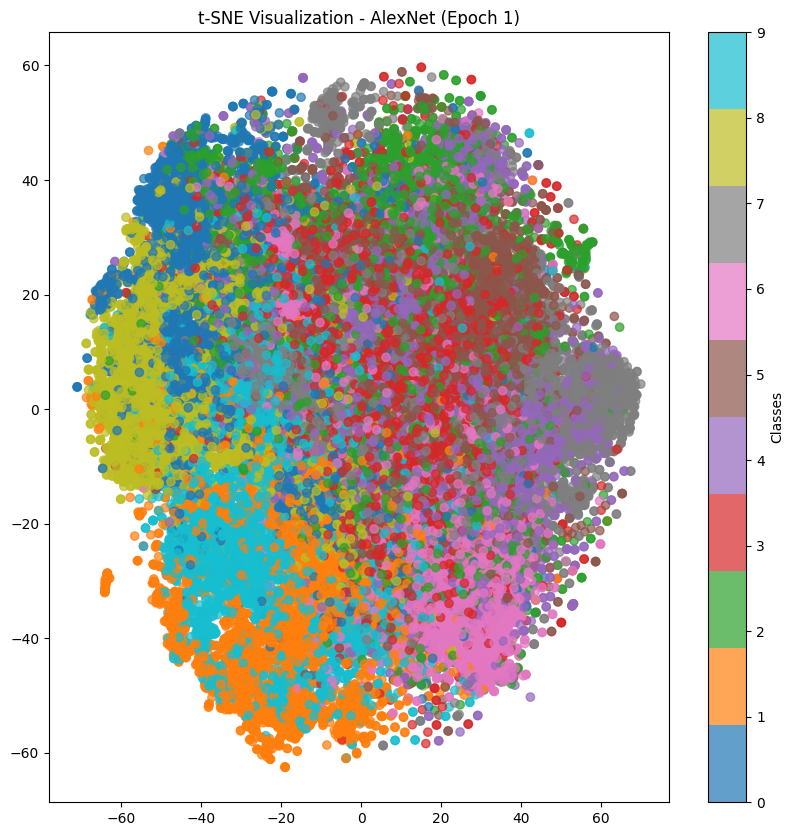

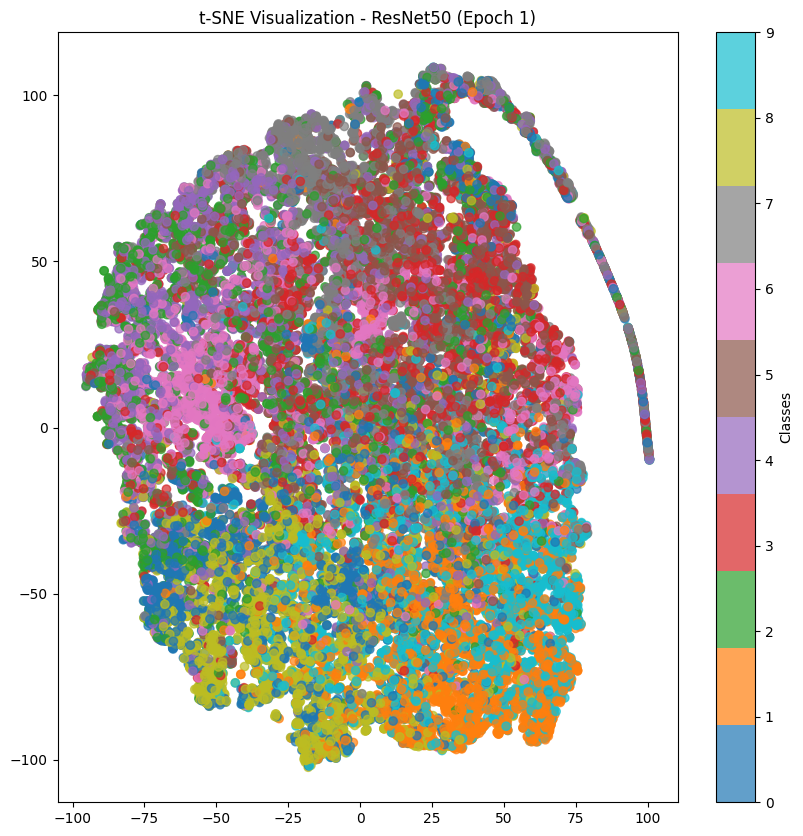

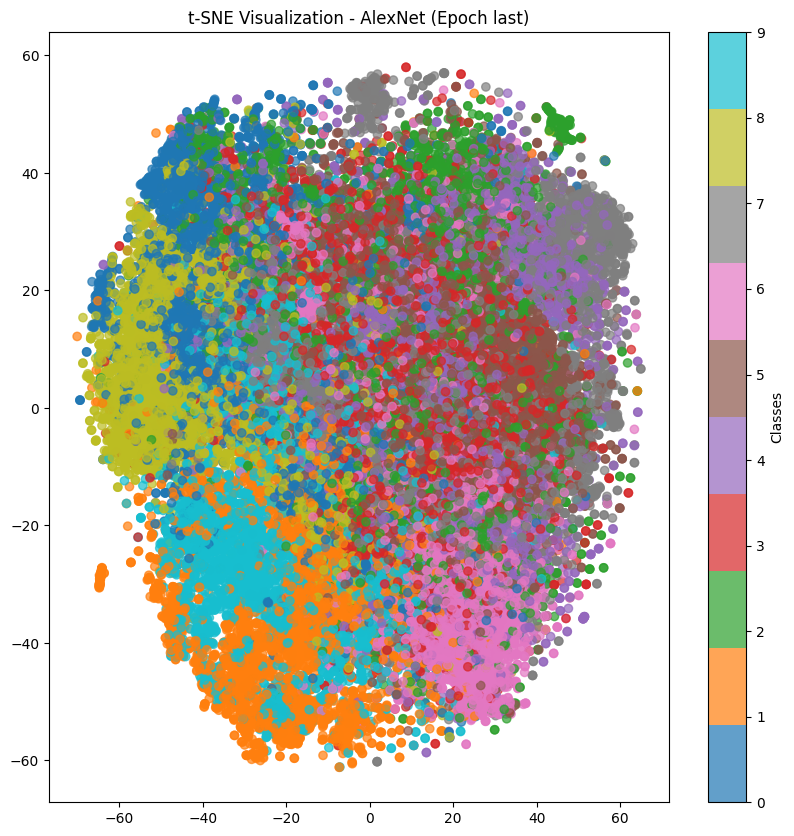

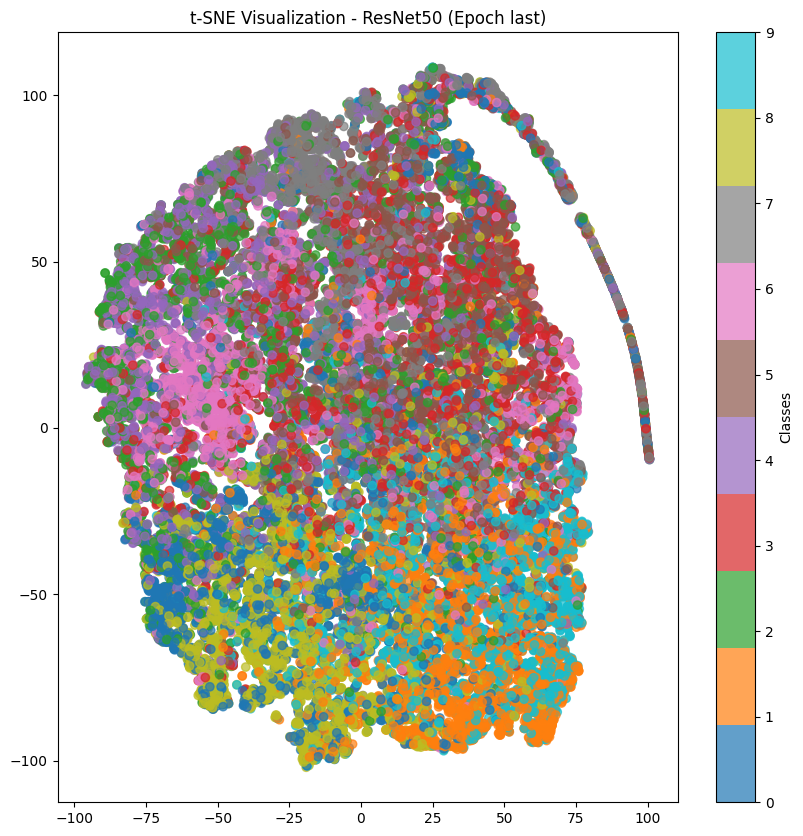

In [16]:
# First epoch t-SNE
tsne_visualization(alexnet, trainloader, epoch=1, model_name="AlexNet")
tsne_visualization(resnet50, trainloader, epoch=1, model_name="ResNet50")

# Last epoch t-SNE
tsne_visualization(alexnet, trainloader, epoch="last", model_name="AlexNet")
tsne_visualization(resnet50, trainloader, epoch="last", model_name="ResNet50")


1. Accuracy:


- AlexNet achieved a test accuracy of 63.99%, significantly outperforming ResNet50, which only achieved 36.20%.


- This indicates that AlexNet is better suited for this task on the CIFAR-10 dataset, likely because of better tuning for smaller datasets and the modifications made to fit the dataset (e.g., the adjusted convolutional and classifier layers).


2. Training Time:


- AlexNet required 320.85 seconds to train for 5 epochs before validation loss stopped improving, while ResNet50 only took 106.14 seconds to train for 3 epochs.


- Although ResNet50 trained faster, it failed to generalize well, as indicated by its much lower test accuracy.


3. Number of Parameters:


- AlexNet has 57 million parameters, while ResNet50 has 23.5 million parameters.


- While ResNet50 is more compact and efficient in terms of parameter count, its lower accuracy suggests it couldn't leverage its depth effectively for this dataset.


#### Conclusion and Recommendation:


Model Choice:


- For this task, AlexNet is the better choice despite having more parameters and longer training time. Its higher accuracy (63.99%) outweighs the computational efficiency of 


- ResNet50, which suffers from poor performance (36.20% accuracy).


Performance vs. Efficiency Trade-off:

- AlexNet offers better overall performance at the cost of more training time and parameters. It is better suited for smaller datasets like CIFAR-10 due to its simpler architecture, which avoids overfitting and trains effectively even with fewer epochs.


- ResNet50, while compact and fast to train, likely struggled to generalize due to the dataset's limited size and complexity. Its deeper architecture might need more epochs or better regularization to avoid overfitting during early training.
Recommendation:

- If accuracy is critical for your application, AlexNet should be chosen despite its higher computational requirements.
- If speed and model size are more important, further tuning of ResNet50 (e.g., learning rate adjustments, data augmentation, or fine-tuning pretrained weights) might improve its performance.